<h1>International football matches: Visualisations</h1>

<h2>Content</h2>

<p>This dataset includes 44,934 results of international football matches starting from the very first official match in 1872 up to 2023. The matches range from FIFA World Cup to FIFI Wild Cup to regular friendly matches. The matches are strictly men's full internationals and the data does not include Olympic Games or matches where at least one of the teams was the nation's B-team, U-23 or a league select team.</p>

results.csv includes the following columns:
<ul>
<li>date - date of the match</li>
<li>home_team - the name of the home team</li>
<li>away_team - the name of the away team</li>
<li>home_score - full-time home team score including extra time, not including penalty-shootouts</li>
<li>away_score - full-time away team score including extra time, not including penalty-shootouts</li>
<li>tournament - the name of the tournament</li>
<li>city - the name of the city/town/administrative unit where the match was played</li>
<li>country - the name of the country where the match was played</li>
<li>neutral - TRUE/FALSE column indicating whether the match was played at a neutral venue</li>
</ul>

shootouts.csv includes the following columns:
<ul>
<li>date - date of the match</li>
<li>home_team - the name of the home team</li>
<li>away_team - the name of the away team</li>
<li>winner - winner of the penalty-shootout</li>
</ul>

goalscorers.csv includes the following columns:
<ul>
<li>date - date of the match</li>
<li>home_team - the name of the home team</li>
<li>away_team - the name of the away team</li>
<li>team - name of the team scoring the goal</li>
<li>scorer - name of the player scoring the goal</li>
<li>own_goal - whether the goal was an own-goal</li>
<li>penalty - whether the goal was a penalty</li>
</ul>

Source: https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the csv files.
results_df = pd.read_csv('results.csv')
shootouts_original = pd.read_csv('shootouts.csv')
goals_original = pd.read_csv('goalscorers.csv')

<h2>Normalize the structure using dataframes to migrate to the database</h2>

In [3]:
# Teams Table
teams = set(results_df['home_team']).union(set(results_df['away_team']))
teams_df = pd.DataFrame(list(teams), columns=['team_name'])
teams_df['team_id'] = range(1, len(teams_df) + 1)

# Tournaments Table
tournaments = set(results_df['tournament'])
tournaments_df = pd.DataFrame(list(tournaments), columns=['tournament_name'])
tournaments_df['tournament_id'] = range(1, len(tournaments_df) + 1)

# Cities Table
cities = results_df[['city', 'country']].drop_duplicates()
cities['city_id'] = range(1, len(cities) + 1)

# Scorers Table
scorers = goals_original['scorer'].drop_duplicates().reset_index(drop=True)
scorers_df = pd.DataFrame(scorers)
scorers_df['scorer_id'] = range(1, len(scorers_df) + 1)

In [4]:
# Matches Table
# Matches DataFrame
matches_df = results_df.copy()

# Merge with team IDs
matches_df = matches_df.merge(teams_df, left_on='home_team', right_on='team_name', how='left')
matches_df.rename(columns={'team_id': 'home_team_id'}, inplace=True)
matches_df.drop('team_name', axis=1, inplace=True)

matches_df = matches_df.merge(teams_df, left_on='away_team', right_on='team_name', how='left')
matches_df.rename(columns={'team_id': 'away_team_id'}, inplace=True)
matches_df.drop('team_name', axis=1, inplace=True)

matches_df.drop('home_team', axis=1, inplace=True)
matches_df.drop('away_team', axis=1, inplace=True)

# Merge with tournament IDs
matches_df = matches_df.merge(tournaments_df, left_on='tournament', right_on='tournament_name', how='left')
matches_df.drop('tournament_name', axis=1, inplace=True)

matches_df.drop('tournament', axis=1, inplace=True)

# Merge with city IDs
matches_df = matches_df.merge(cities, on=['city', 'country'], how='left')

matches_df.drop('city', axis=1, inplace=True)
matches_df.drop('country', axis=1, inplace=True)

# Assign match_id
matches_df['match_id'] = range(1, len(matches_df) + 1)

In [5]:
# Shootouts table
# Merging to get match_id for shootouts
shootouts_original = shootouts_original.merge(matches_df[['date', 'home_team_id', 'away_team_id', 'match_id']], on='date', how='left')

# Getting the winner_team_id based on the winner's name
shootouts_original['winner_team_id'] = shootouts_original.apply(lambda row: row['home_team_id'] if row['home_team'] == row['winner'] else row['away_team_id'], axis=1)

# Creating shootouts_df
shootouts_original['shootout_id'] = range(1, len(shootouts_original) + 1)
shootouts_df = shootouts_original[['shootout_id', 'match_id', 'winner_team_id']]

In [6]:
# Goals Table
# Merging to get match_id for goals
goals_original = goals_original.merge(matches_df[['date', 'home_team_id', 'away_team_id', 'match_id']], on='date', how='left')

# Getting the scoring_team_id based on the team's name
goals_original['scoring_team_id'] = goals_original.apply(lambda row: row['home_team_id'] if row['home_team'] == row['team'] else row['away_team_id'], axis=1)

# Creating goals_df
goals_original['goal_id'] = range(1, len(goals_original) + 1)
goals_df = goals_original[['goal_id', 'match_id', 'scoring_team_id', 'scorer', 'own_goal', 'penalty']]

# Merge goals_df with scorers_df to get the scorer_id for each scorer name
goals_df = goals_df.merge(scorers_df, left_on='scorer', right_on='scorer', how='left')

# Drop the scorer column from goals_df, as you'll be using scorer_id now
goals_df.drop('scorer', axis=1, inplace=True)

<h2> Create the database </h2>

In [7]:
# Connect to database
conn = sqlite3.connect('football_international_matches.db')
c = conn.cursor()

# Enable foreign key constraint
c.execute("PRAGMA foreign_keys = ON")

query = '''DROP TABLE IF EXISTS  teams'''
c.execute(query)
query = '''DROP TABLE IF EXISTS  tournaments'''
c.execute(query)
query = '''DROP TABLE IF EXISTS  cities'''
c.execute(query)
query = '''DROP TABLE IF EXISTS  scorers'''
c.execute(query)
query = '''DROP TABLE IF EXISTS  matches'''
c.execute(query)
query = '''DROP TABLE IF EXISTS  shootouts'''
c.execute(query)
query = '''DROP TABLE IF EXISTS  goals'''
c.execute(query)

#################################
# Create tables with constraints
#################################

# teams table
c.execute("""
CREATE TABLE teams (
    team_id INTEGER PRIMARY KEY,
    team_name TEXT NOT NULL
);
""")

# tournaments table
c.execute("""
CREATE TABLE tournaments (
    tournament_id INTEGER PRIMARY KEY,
    tournament_name TEXT NOT NULL UNIQUE
);
""")

# cities table
c.execute("""
CREATE TABLE cities (
    city_id INTEGER PRIMARY KEY,
    city TEXT NOT NULL,
    country TEXT NOT NULL,
    UNIQUE(city, country)
);
""")

# scorers table
c.execute("""
CREATE TABLE scorers (
    scorer_id INTEGER PRIMARY KEY,
    scorer TEXT UNIQUE
);
""")

# matches table
c.execute("""
CREATE TABLE matches (
    match_id INTEGER PRIMARY KEY,
    date TEXT,
    home_team_id INTEGER,
    away_team_id INTEGER,
    home_score INTEGER,
    away_score INTEGER,
    tournament_id INTEGER,
    city_id INTEGER,
    neutral BOOLEAN,
    FOREIGN KEY (home_team_id) REFERENCES teams(team_id),
    FOREIGN KEY (away_team_id) REFERENCES teams(team_id),
    FOREIGN KEY (tournament_id) REFERENCES tournaments(tournament_id),
    FOREIGN KEY (city_id) REFERENCES cities(city_id)
);
""")

# shootouts table
c.execute("""
CREATE TABLE shootouts (
    shootout_id INTEGER PRIMARY KEY,
    match_id INTEGER NOT NULL,
    winner_team_id INTEGER NOT NULL,
    FOREIGN KEY (match_id) REFERENCES matches(match_id),
    FOREIGN KEY (winner_team_id) REFERENCES teams(team_id)
);
""")

# goals table
c.execute("""
CREATE TABLE goals (
    goal_id INTEGER PRIMARY KEY,
    match_id INTEGER NOT NULL,
    scoring_team_id INTEGER NOT NULL,
    scorer_id INTEGER NOT NULL,
    own_goal BOOLEAN NOT NULL,
    penalty BOOLEAN NOT NULL,
    FOREIGN KEY (match_id) REFERENCES matches(match_id),
    FOREIGN KEY (scoring_team_id) REFERENCES teams(team_id),
    FOREIGN KEY (scorer_id) REFERENCES scorers(scorer_id)
);
""")

# Commit the changes
conn.commit()

# Add the data to the tables
teams_df.to_sql('teams', conn, if_exists='append', index=False)
tournaments_df.to_sql('tournaments', conn, if_exists='append', index=False)
cities.to_sql('cities', conn, if_exists='append', index=False)
scorers_df.to_sql('scorers', conn, if_exists='append', index=False)
matches_df.to_sql('matches', conn, if_exists='append', index=False)
shootouts_df.to_sql('shootouts', conn, if_exists='append', index=False)
goals_df.to_sql('goals', conn, if_exists='append', index=False)

<h2>Queries</h2>

<b>What are the top 10 scoring teams?</b>

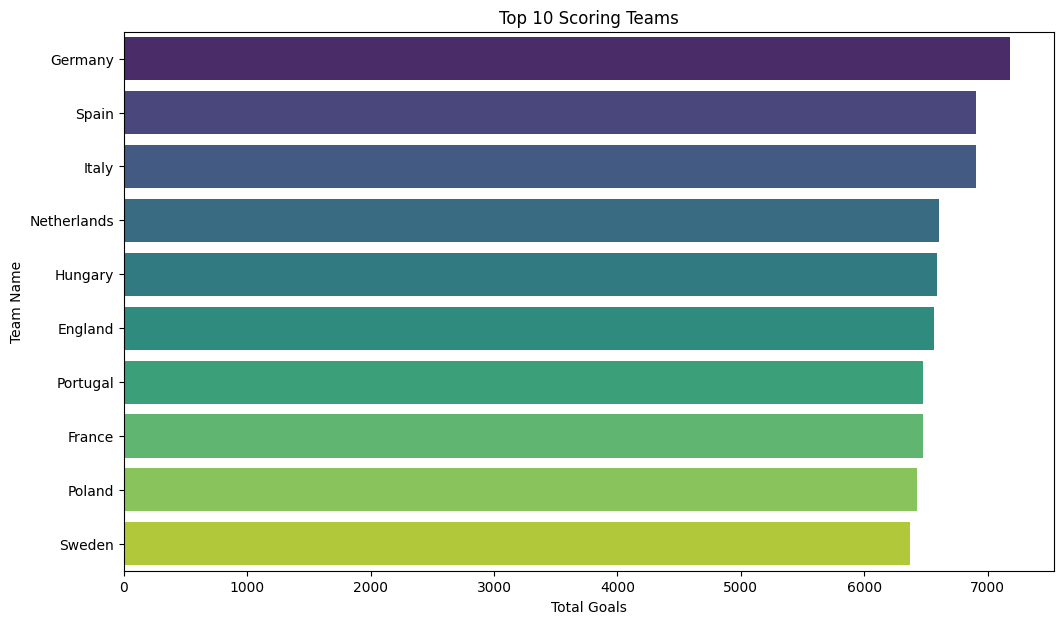

In [8]:
# Query to get goals for each team
query = """
SELECT t.team_name, COUNT(g.goal_id) as total_goals
FROM goals g
JOIN teams t ON g.scoring_team_id = t.team_id
GROUP BY t.team_name
ORDER BY total_goals DESC
LIMIT 10; 
"""

# Use pandas to get the result of the query into a dataframe
top_teams = pd.read_sql_query(query, conn)

# Plotting
plt.figure(figsize=(12, 7))
sns.barplot(data=top_teams, x='total_goals', y='team_name', palette='viridis')
plt.title('Top 10 Scoring Teams')
plt.xlabel('Total Goals')
plt.ylabel('Team Name')
plt.show()

<b>Who are the top 20 scoring players?</b>

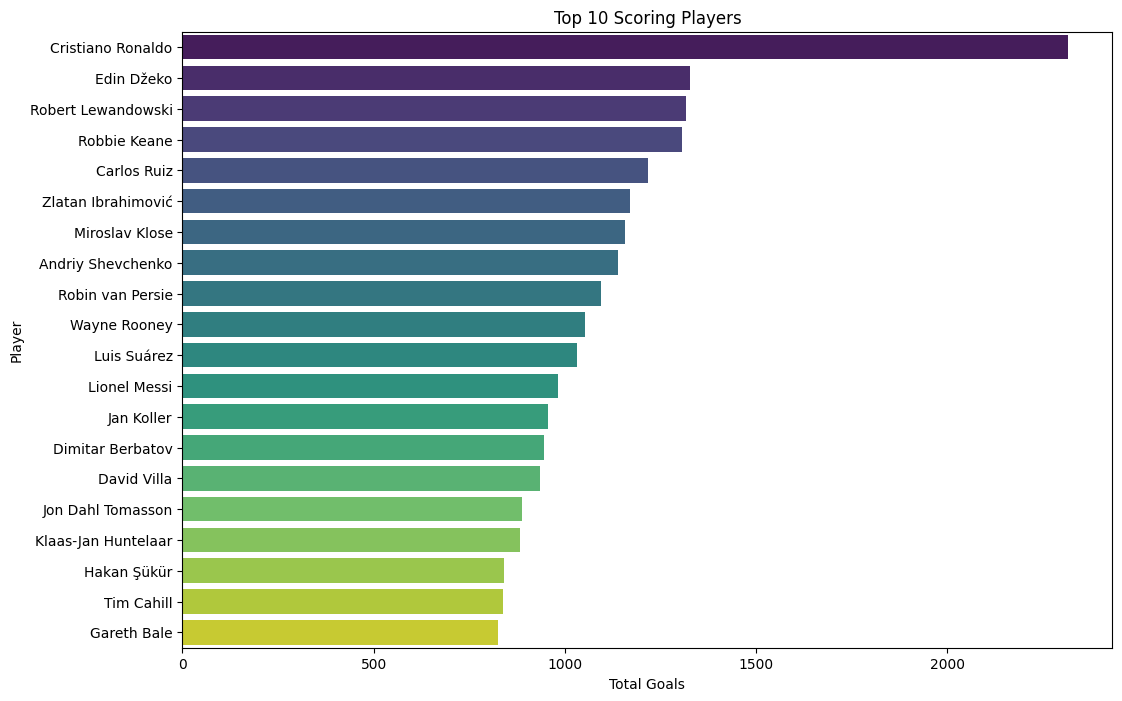

In [12]:
# Query to count the number of goals by each scorer_id
goal_counts = pd.read_sql("""
    SELECT scorer_id, COUNT(goal_id) as total_goals
    FROM goals
    GROUP BY scorer_id
    ORDER BY total_goals DESC
    LIMIT 20
""", conn)

# Merge the results with the scorers table to get the player names
top_scorers = goal_counts.merge(pd.read_sql("SELECT * FROM scorers", conn), on="scorer_id")

# Plotting the results
plt.figure(figsize=(12,8))
sns.barplot(data=top_scorers, x="total_goals", y="scorer", palette="viridis")
plt.title('Top 10 Scoring Players')
plt.xlabel('Total Goals')
plt.ylabel('Player')
plt.show()

<b>What was the scoring performance of Argentina over time?</b>

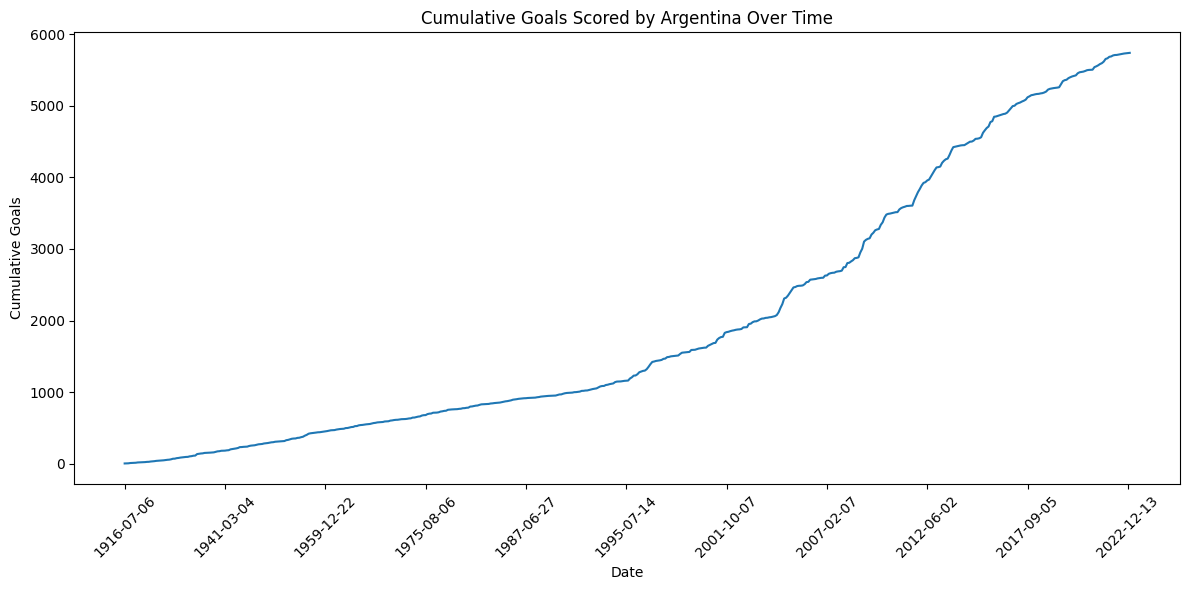

In [15]:
# SQL query to get the count of goals scored by Argentina on each date
query = """
SELECT m.date, COUNT(g.goal_id) as goals_scored
FROM matches m
JOIN goals g ON m.match_id = g.match_id
WHERE g.scoring_team_id = (
    SELECT team_id FROM teams WHERE team_name = 'Argentina'
)
GROUP BY m.date
ORDER BY m.date;
"""

# Fetching the data into a Pandas dataframe
df_argentina_goals = pd.read_sql_query(query, conn)

# Calculate the cumulative sum of goals over time
df_argentina_goals['cumulative_goals'] = df_argentina_goals['goals_scored'].cumsum()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_argentina_goals, x='date', y='cumulative_goals')

# Modify x-ticks for better readability
dates = df_argentina_goals['date'].tolist()
# Choose every nth date to be displayed, for instance, every 20th date
n = len(dates) // 10  # display roughly 10 x-tick labels
plt.xticks(dates[::n], rotation=45)

plt.title('Cumulative Goals Scored by Argentina Over Time')
plt.ylabel('Cumulative Goals')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

<b>How does the distribution of goals looks like (penalties, own goals, regular goals)?</b>

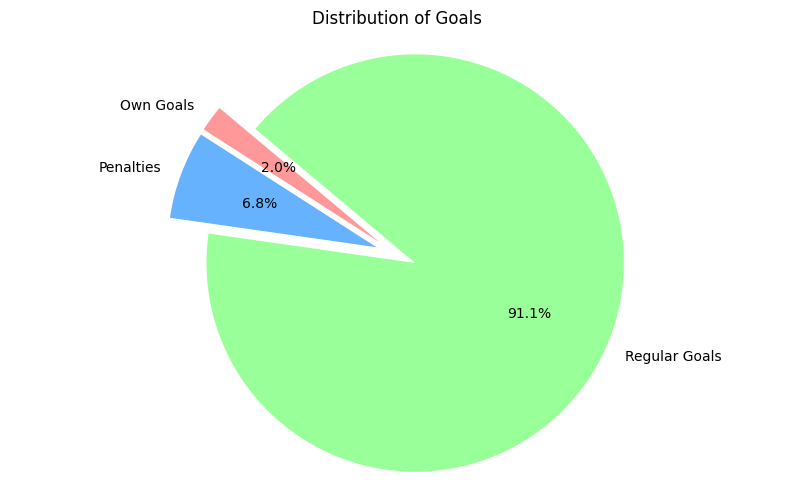

In [23]:
# SQL Query
query = """
SELECT 
    SUM(CASE WHEN own_goal = 1 THEN 1 ELSE 0 END) as own_goals,
    SUM(CASE WHEN penalty = 1 THEN 1 ELSE 0 END) as penalties,
    SUM(CASE WHEN own_goal = 0 AND penalty = 0 THEN 1 ELSE 0 END) as regular_goals
FROM goals;
"""

df_goals_distribution = pd.read_sql_query(query, conn)

# Extracting values for the pie chart
own_goals = df_goals_distribution['own_goals'].values[0]
penalties = df_goals_distribution['penalties'].values[0]
regular_goals = df_goals_distribution['regular_goals'].values[0]

# Pie chart
labels = ['Own Goals', 'Penalties', 'Regular Goals']
sizes = [own_goals, penalties, regular_goals]
colors = ['#ff9999', '#66b2ff', '#99ff99']
explode = (0.1, 0.1, 0.1)  # 'explode' a slice if required

plt.figure(figsize=(10, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.title('Distribution of Goals')
plt.show()